# Predicting Memorability

Below is a complete example of predicting the video memorability using the video captions with a simple 3-layer NN to get you started. 

Note:

*   You don't have to use the same framework as used here
*   Try out some other variations on this model. (layers, features etc.)
*   Use this as a guide example, not the solution. 




**Some very useful functions for colabs! **

You need to calculate the Spearman score eventually

In [0]:
def Get_score(Y_pred,Y_true):
    '''Calculate the Spearmann"s correlation coefficient'''
    Y_pred = np.squeeze(Y_pred)
    Y_true = np.squeeze(Y_true)
    if Y_pred.shape != Y_true.shape:
        print('Input shapes don\'t match!')
    else:
        if len(Y_pred.shape) == 1:
            Res = pd.DataFrame({'Y_true':Y_true,'Y_pred':Y_pred})
            score_mat = Res[['Y_true','Y_pred']].corr(method='spearman',min_periods=1)
            print('The Spearman\'s correlation coefficient is: %.3f' % score_mat.iloc[1][0])
        else:
            for ii in range(Y_pred.shape[1]):
                Get_score(Y_pred[:,ii],Y_true[:,ii])

If working on Colabs I would suggest mapping your drive. It helps load the data in from Google Drive.

In [521]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/CA684/Assignment/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [522]:
!pip install pyprind

Install this package if you are missing it. Similar to tqdm.

# Predicting video memorability using captions (Jointly)

In [0]:
import pandas as pd
from keras import Sequential
from keras import layers
from keras import regularizers
import numpy as np
from string import punctuation
import pyprind
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
# for reproducability
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

## 1. Loading the captions and the memorability scores

In [0]:
# load labels and captions
def read_caps(fname):
    """Load the captions into a dataframe"""
    vn = []
    cap = []
    df = pd.DataFrame();
    with open(fname) as f:
        for line in f:
            pairs = line.split()
            vn.append(pairs[0])
            cap.append(pairs[1])
        df['video']=vn
        df['caption']=cap
    return df


# load the captions
cap_path = '/content/drive/My Drive/CA684/Assignment/dev-set_video-captions.txt'
df_cap=read_caps(cap_path)

# load the ground truth values
label_path = '/content/drive/My Drive/CA684/Assignment/'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [526]:
print(df_cap)

               video                                            caption
0        video3.webm                 blonde-woman-is-massaged-tilt-down
1        video4.webm  roulette-table-spinning-with-ball-in-closeup-shot
2        video6.webm                                      khr-gangsters
3        video8.webm               medical-helicopter-hovers-at-airport
4       video10.webm               couple-relaxing-on-picnic-crane-shot
5       video12.webm                       passing-by-older-man-reading
6       video13.webm      christmas-village-and-national-christmas-tree
7       video16.webm  unhappy-friends-looking-for-something-interest...
8       video17.webm                        hoover-dam-tourists-traffic
9       video18.webm  happy-girl-stretching-and-relaxing-on-the-station
10      video19.webm                              bread-on-the-conveyor
11      video20.webm  close-up-on-racks-of-computer-equipment-with-f...
12      video21.webm                    modern-family-overdue-bu

In [527]:
print(labels)

               video  short-term_memorability  nb_short-term_annotations  \
0        video3.webm                    0.924                         34   
1        video4.webm                    0.923                         33   
2        video6.webm                    0.863                         33   
3        video8.webm                    0.922                         33   
4       video10.webm                    0.950                         34   
5       video12.webm                    0.783                         74   
6       video13.webm                    0.861                         40   
7       video16.webm                    0.834                         33   
8       video17.webm                    0.777                         43   
9       video18.webm                    0.863                         33   
10      video19.webm                    0.980                         55   
11      video20.webm                    0.955                         40   
12      vide

In [528]:
counts = Counter()
# setup prograss tracker
pbar = pyprind.ProgBar(len(df_cap['caption']), title='Counting word occurrences')
for i, cap in enumerate(df_cap['caption']):
    # replace punctuations with space
    # convert words to lower case 
    text = ''.join([c if c not in punctuation else ' ' for c in cap]).lower()
    #print( "Text: {}".format(text) )                      #print( "Caption: {}".format(df_cap.loc[i,'caption']) )
    df_cap.loc[i,'caption'] = text
    pbar.update()
    counts.update(text.split())

Counting word occurrences
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05


In [529]:
print(counts)
print(len(counts))

Counter({'in': 2105, 'the': 1835, 'on': 1724, 'and': 1444, 'a': 1181, 'with': 996, 'woman': 899, 'of': 836, 'at': 762, 'young': 724, 'man': 559, 'slow': 495, 'motion': 452, 'to': 416, 'couple': 318, 'sitting': 304, 'girl': 291, 'happy': 279, 'beach': 270, 'park': 256, 'up': 255, 'walking': 237, 'close': 230, 'camera': 230, 'her': 219, 'using': 218, 'shot': 215, 'smiling': 198, 'looking': 195, 'two': 191, 'by': 189, 'people': 188, 'from': 188, 'tablet': 184, 'is': 181, 'water': 171, 'through': 156, 'female': 150, 'computer': 149, 'view': 149, 'laptop': 139, 'playing': 137, 'sunset': 137, 'beautiful': 133, 'videoblocks': 131, 'his': 131, 'running': 130, 'talking': 129, 'city': 128, 'working': 127, 'eating': 126, 'little': 126, 'family': 125, 'mother': 124, 'background': 122, 'home': 122, 'standing': 121, 'for': 115, 'phone': 115, 'or': 114, 'sea': 113, 'national': 112, 'african': 111, 'attractive': 111, 'tree': 107, 'snow': 103, 'their': 102, 'drinking': 102, 'hands': 102, 'steadicamof':

In [530]:
df_cap.head()

,video,caption
0,video3.webm,blonde woman is massaged tilt down
1,video4.webm,roulette table spinning with ball in closeup shot
2,video6.webm,khr gangsters
3,video8.webm,medical helicopter hovers at airport
4,video10.webm,couple relaxing on picnic crane shot


## 2. Preprocessing the captions for model inputs
### Separate words and count each word's occurrence

### Maping each unique word to an integer (one-hot encoding)

In [531]:
# build the word index
len_token = len(counts)
tokenizer = Tokenizer(num_words=len_token)
print(len_token)

5191


In [0]:
tokenizer.fit_on_texts(list(df_cap.caption.values)) #fit a list of captions to the tokenizer
#the tokenizer vectorizes a text corpus, by turning each text into either a sequence of integers 

In [533]:
print(len(tokenizer.word_index))

5191


In [0]:
one_hot_res = tokenizer.texts_to_matrix(list(df_cap.caption.values),mode='binary')
sequences = tokenizer.texts_to_sequences(list(df_cap.caption.values))

In [535]:
#Just to visualise some stuff in sequences and counts
print(sequences[0]) # prints location of words from caption 0 'blonde woman is massaged tilt down'
print(counts['blonde']) # no. of occurences of 'blonde'
n=3
print('Least Common: ', counts.most_common()[:-n-1:-1])       # n least common elements
print('Most Common: ',counts.most_common(n))                     # n most common elements

[724, 7, 35, 884, 384, 91]
10
Least Common:  [('unknown', 1), ('handheldshowing', 1), ('longof', 1)]
Most Common:  [('in', 2105), ('the', 1835), ('on', 1724)]


### Making all the sequences same length by padding zeros from 1 to (N - len(seq))

In [0]:
# calculating max length
max_len = 50

### Making sequences index same length

In [537]:
print(sequences[0]) # length of 1st sequence

[724, 7, 35, 884, 384, 91]


In [538]:
np.zeros

<function numpy.zeros>

In [539]:
X_seq = np.zeros((len(sequences),max_len))
for i in range(len(sequences)):
    n = len(sequences[i])
    if n==0:
        print(i)
    else:
        X_seq[i,-n:] = sequences[i]
X_seq.shape

(6000, 50)

In [540]:
print(X_seq[5999,:])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  44.  71.
 243.   7.  26.  34.  39.   1. 872. 222.]


In [541]:
print(X_seq[0,:]) # length of 1st sequence after padding the caption with zeros.

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 724.   7.  35. 884. 384.  91.]


***One hot encoding are already same length so no need to change***

## 3. Building network model - using Keras library


**Remember: Split data set to training and test data**

The targets here are the short-term and long-term scores

In [0]:
Y = labels[['short-term_memorability','long-term_memorability']].values # targets
X = X_seq # sequences

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

**Look at the shape of our data for some context**

In [544]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4800, 50)
X_test (1200, 50)
Y_train (4800, 2)
Y_test (1200, 2)


###Construction

A dense layer is just a regular layer of neurons in a NN. Each neuron recieves input from all the neurons in the previous layer, thus densely connected. 


![alt text](http://www.ece.utep.edu/research/webfuzzy/docs/kk-thesis/kk-thesis-html/img33.gif)


The layer has a weight matrix W, a bias vector b, and the activations of previous layer a. The following is the docstring of class Dense from the keras documentation:

*output = activation(dot(input, kernel) + bias)*

where activation is the element-wise activation function passed as the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer

In [0]:
# add dropout - Helps prevent overfitting
# add regularizers - Regularizers allow to apply penalties on layer parameters or layer activity during optimization.
# activations - Used to determine the output of network. It maps the resulting values in between 0 to 1 or -1 to 1 etc. (depending upon the function).

model = Sequential() # The Sequential model is a linear stack of layers.

# You can simply add layers via the .add() method:
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005),input_shape=(max_len,))) # Just your regular densely-connected NN layer.
model.add(layers.Dropout(0.5)) #Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training; helps prevent overfitting.
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.0005)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

###Compilation

Before training a model, you need to configure the learning process, which is done via the compile method. 

It receives three arguments:

1.   An optimizer
2.   A loss function
3.   A list of metrics


In [0]:
# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

###Training

Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the *fit* function.

In [547]:
# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 10s 2ms/step - loss: 0.3441 - acc: 0.6402 - val_loss: 0.3777 - val_acc: 0.7075
Epoch 2/20
4800/4800 [==============================] - 1s 179us/step - loss: 0.2666 - acc: 0.6310 - val_loss: 0.2659 - val_acc: 0.7083
Epoch 3/20
4800/4800 [==============================] - 1s 179us/step - loss: 0.2003 - acc: 0.6373 - val_loss: 0.1594 - val_acc: 0.7092
Epoch 4/20
4800/4800 [==============================] - 1s 188us/step - loss: 0.1427 - acc: 0.6342 - val_loss: 0.0988 - val_acc: 0.7033
Epoch 5/20
4800/4800 [==============================] - 1s 184us/step - loss: 0.0986 - acc: 0.6354 - val_loss: 0.0740 - val_acc: 0.6992
Epoch 6/20
4800/4800 [==============================] - 1s 186us/step - loss: 0.0728 - acc: 0.6419 - val_loss: 0.0581 - val_acc: 0.7008
Epoch 7/20
4800/4800 [==============================] - 1s 188us/step - loss: 0.0527 - acc: 0.6558 - val_loss: 0.0473 - val_acc: 0.7075
E

### Visualising the validation and training loss

This is a basic way to help us to see if we are overfitting...
How?

Try train the model for a *LOT* more iterations and see what happens...

I would make sure to save the images, also a white background makes the plots look nice in your reports :). I'll let you figure out how to do that!

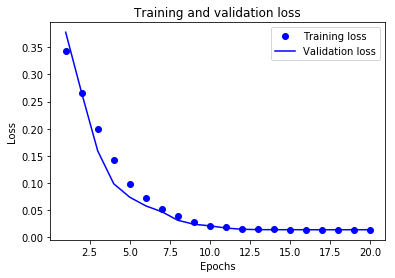

In [548]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

What is training and validation accuracy?

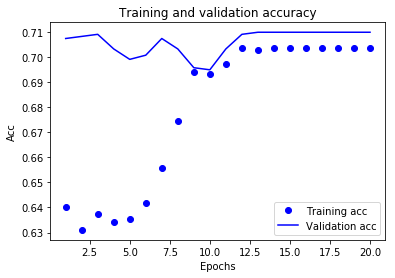

In [549]:
plt.figure()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()


Okay lets make some predictions now on the newly trained model....

In [550]:
predictions = model.predict(X_test)
print(predictions)
Get_score(predictions, Y_test) # Try remember what the Spearman scores actually mean!

[[0.8604417  0.77877283]
 [0.8604417  0.77877283]
 [0.8669752  0.78218603]
 ...
 [0.85609937 0.7765988 ]
 [0.86730397 0.7908574 ]
 [0.85825044 0.76997334]]
The Spearman's correlation coefficient is: 0.022
The Spearman's correlation coefficient is: -0.018


Not great, but that's the point.. Now what can you do to improve this?

Maybe try a different model, the one used here is relatively simple. 

What about all the other features?

#4.  Predicting video memorability using captions (one-hot res)

Some nice one-hot encoding..
Not sure what it is? Read more [here](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

In [551]:
one_hot_res.shape

(6000, 5191)

Throwing everything into one big cell because we already broke it down in the previous section

In [552]:
Y = labels[['short-term_memorability','long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

# add dropout
# add regularizers
model = Sequential()
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(len_token,)))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(10,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))

# compile the model 
model.compile(optimizer='rmsprop',loss='mse',metrics=['accuracy'])

# training the model 
history = model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))

Train on 4800 samples, validate on 1200 samples
Epoch 1/20
4800/4800 [==============================] - 10s 2ms/step - loss: 0.0910 - acc: 0.4396 - val_loss: 0.0460 - val_acc: 0.2900
Epoch 2/20
4800/4800 [==============================] - 1s 217us/step - loss: 0.0449 - acc: 0.4885 - val_loss: 0.0205 - val_acc: 0.2925
Epoch 3/20
4800/4800 [==============================] - 1s 214us/step - loss: 0.0284 - acc: 0.5646 - val_loss: 0.0154 - val_acc: 0.7100
Epoch 4/20
4800/4800 [==============================] - 1s 214us/step - loss: 0.0214 - acc: 0.6502 - val_loss: 0.0146 - val_acc: 0.7100
Epoch 5/20
4800/4800 [==============================] - 1s 216us/step - loss: 0.0185 - acc: 0.6852 - val_loss: 0.0142 - val_acc: 0.7100
Epoch 6/20
4800/4800 [==============================] - 1s 212us/step - loss: 0.0171 - acc: 0.7040 - val_loss: 0.0141 - val_acc: 0.7100
Epoch 7/20
4800/4800 [==============================] - 1s 213us/step - loss: 0.0160 - acc: 0.7035 - val_loss: 0.0141 - val_acc: 0.7100
E

In [553]:
predictions = model.predict(X_test)
print(predictions.shape)

(1200, 2)


In [0]:
Y_pred_train = model.predict(X_train)
#Y_pred_val = model.predict(X_test)

In [555]:
#print('='*20)
#print('Training Scores')
#Get_score(Y_pred_train,Y_train)
print('='*20)
Get_score(predictions, Y_test)

The Spearman's correlation coefficient is: 0.278
The Spearman's correlation coefficient is: 0.149


#Saving your model

Don't forget to save your model!

N.B. ***you do not have to use keras***. I just used it as a simple example. There are other frameworks with different ways to save e.g. pytorch (*torch.save*) !


**From Keras Documentation**

You can use *model.save(filepath)* to save a Keras model into a single HDF5 file which will contain:

the architecture of the model, allowing to re-create the model
the weights of the model
the training configuration (loss, optimizer)
the state of the optimizer, allowing to resume training exactly where you left off.

In [0]:
#model.save('Model/my_model.h5')  # creates a HDF5 file 'my_model.h5'

Importing ground truth dataset

In [0]:
label_path = '/content/drive/My Drive/CA684_Assignment_Data/dev-set/'
labels=pd.read_csv(label_path+'dev-set_ground-truth.csv')

In [558]:
len(labels)

6000

In [0]:

Y = labels[['short-term_memorability','long-term_memorability']].values

**Custom Models to predict video memorability**

**Using ANN with labels and one-hot encoding**

In [560]:
model = Sequential()
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(X.shape[1],)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.35))
model.add(layers.Dense(2,activation='relu'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 220)               1142240   
_________________________________________________________________
dropout_133 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_218 (Dense)            (None, 220)               48620     
_________________________________________________________________
dropout_134 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_219 (Dense)            (None, 220)               48620     
_________________________________________________________________
dropout_135 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 2)                 442       
Total para

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [562]:
from keras.optimizers import Nadam
opt=Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.07)
model.compile(optimizer=opt,loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=25,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/25
3840/3840 [==============================] - 10s 3ms/step - loss: 0.3656 - acc: 0.5859 - val_loss: 0.2102 - val_acc: 0.6813
Epoch 2/25
3840/3840 [==============================] - 1s 227us/step - loss: 0.2009 - acc: 0.6604 - val_loss: 0.1570 - val_acc: 0.6813
Epoch 3/25
3840/3840 [==============================] - 1s 231us/step - loss: 0.1516 - acc: 0.6794 - val_loss: 0.1420 - val_acc: 0.6823
Epoch 4/25
3840/3840 [==============================] - 1s 232us/step - loss: 0.1274 - acc: 0.6919 - val_loss: 0.1178 - val_acc: 0.6802
Epoch 5/25
3840/3840 [==============================] - 1s 236us/step - loss: 0.1136 - acc: 0.7055 - val_loss: 0.1101 - val_acc: 0.6802
Epoch 6/25
3840/3840 [==============================] - 1s 229us/step - loss: 0.1038 - acc: 0.7117 - val_loss: 0.1078 - val_acc: 0.6698
Epoch 7/25
3840/3840 [==============================] - 1s 229us/step - loss: 0.0950 - acc: 0.7237 - val_loss: 0.1081 - val_acc: 0.6677
Ep

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
Y_pred = model.predict(X_val)

**Visualising how our models fits training and validation **

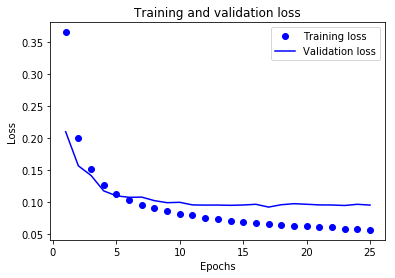

In [565]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Getting the score of short-tem memorability test using ANN**

In [566]:
Get_score(Y_pred[:,0],Y_val[:,0])

The Spearman's correlation coefficient is: 0.409


**Getting the score of long-tem memorability test using ANN**

In [567]:
Get_score(Y_pred[:,1],Y_val[:,1])

The Spearman's correlation coefficient is: 0.136


**Using Support Vector Regression with labels and one-hot encoding**

In [0]:
from sklearn.svm import SVR

In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

In [0]:
Y1 = labels[['short-term_memorability']].values
Y2 = labels[['long-term_memorability']].values
X = one_hot_res;
X_train, X_test, Y_train, Y1_test = train_test_split(X,Y1, test_size=0.2, random_state=42)

clf_SVR=SVR(kernel='linear',degree=1)
clf_SVR.fit(X_train,Y_train.ravel())
pred_SVR1=clf_SVR.predict(X_test)

X_train, X_test, Y_train, Y2_test = train_test_split(X,Y2, test_size=0.2, random_state=42)

clf_SVR=SVR(kernel='linear',degree=1)
clf_SVR.fit(X_train,Y_train.ravel())
pred_SVR2=clf_SVR.predict(X_test)






**Short-term memorability score with SVR**

In [571]:
Get_score(pred_SVR1,Y1_test)

The Spearman's correlation coefficient is: 0.334


**Long term memorability score with SVR**

In [572]:
Get_score(pred_SVR2,Y2_test)

The Spearman's correlation coefficient is: 0.141


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.2, random_state=42)

**Using Random Forest Regressor with captions and one-hot encoding**

In [574]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()
clf.fit(X_train,Y_train)
RFR_pred = clf.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


**Short-term memorability score with RFR**

In [591]:

Get_score(RFR_pred[:,0],Y_val[:,0])

The Spearman's correlation coefficient is: 0.394


**Long-term memorability score with RFR**

In [576]:
Get_score(RFR_pred[:,1],Y_val[:,1])

The Spearman's correlation coefficient is: 0.152


In [577]:
type(x)

pandas.core.frame.DataFrame

**Using Linear Regression with captions and one-hot encoding**

In [578]:
from sklearn.linear_model import LinearRegression
clf = LinearRegression()
clf.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [0]:
lr_test=clf.predict(X_test)

**Short-term memorability score with LR**

In [581]:
Get_score(lr_test[:,0],Y_val[:,0])

The Spearman's correlation coefficient is: 0.166


**Long-term memorability score with LR**

In [583]:
Get_score(lr_test[:,1],Y_val[:,1])

The Spearman's correlation coefficient is: 0.021


**Using C3D feature to predict short-term and long-term video memorability**

---



Importing C3D features

In [584]:
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
import pandas as pd

def read_C3D(fname):
    """Scan vectors from file"""
    with open(fname) as f:
        for line in f:
            C3D =[float(item) for item in line.split()] # convert to float type, using default separator
    return C3D
c3d_path = Path('/content/drive/My Drive/CA684_Assignment_Data/dev-set/C3D')
list(c3d_path.glob('*.txt'))

c3d_feat_dict ={}

for file in tqdm (list(c3d_path.glob('*.txt'))):
  key = file.with_suffix('.webm').name
  c3d_feat_dict[key] = read_C3D(file)


c3d_feat= pd.DataFrame(c3d_feat_dict).T.reset_index()
c3d_feat= c3d_feat.rename(columns={'index':'video'})

In [0]:
x=c3d_feat.iloc[:,1:]

In [586]:
x.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,1.400000e-07,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,6.610000e-06,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,8.052350e-03,0.003992,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,2.106000e-05,0.000002,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05


**Designing a ANN to with 4 deep layers**

In [592]:
model = Sequential()
model.add(layers.Dense(220,activation='relu',kernel_regularizer=None,input_shape=(x.shape[1],)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(220,activation='relu',kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2,activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 220)               22440     
_________________________________________________________________
dropout_138 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_225 (Dense)            (None, 220)               48620     
_________________________________________________________________
dropout_139 (Dropout)        (None, 220)               0         
_________________________________________________________________
dense_226 (Dense)            (None, 2)                 442       
Total params: 71,502
Trainable params: 71,502
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train, X_val, Y_train, Y_val = train_test_split(x,Y, test_size=0.2, random_state=42)

In [594]:
from keras.optimizers import Nadam
opt=Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.07)
model.compile(optimizer=opt,loss=['mae'],metrics=['acc'])
history=model.fit(x=X_train,y=Y_train,batch_size=50,epochs=5,validation_split=0.2,shuffle=True,verbose=True)

Train on 3840 samples, validate on 960 samples
Epoch 1/20
3840/3840 [==============================] - 9s 2ms/step - loss: 0.2015 - acc: 0.6852 - val_loss: 0.1057 - val_acc: 0.6813
Epoch 2/20
3840/3840 [==============================] - 1s 137us/step - loss: 0.1019 - acc: 0.7089 - val_loss: 0.0921 - val_acc: 0.6813
Epoch 3/20
3840/3840 [==============================] - 1s 138us/step - loss: 0.0955 - acc: 0.7091 - val_loss: 0.0929 - val_acc: 0.6813
Epoch 4/20
3840/3840 [==============================] - 1s 134us/step - loss: 0.0937 - acc: 0.7091 - val_loss: 0.0909 - val_acc: 0.6813
Epoch 5/20
3840/3840 [==============================] - 1s 143us/step - loss: 0.0931 - acc: 0.7091 - val_loss: 0.0889 - val_acc: 0.6813
Epoch 6/20
3840/3840 [==============================] - 1s 148us/step - loss: 0.0925 - acc: 0.7091 - val_loss: 0.0894 - val_acc: 0.6813
Epoch 7/20
3840/3840 [==============================] - 1s 154us/step - loss: 0.0923 - acc: 0.7091 - val_loss: 0.0891 - val_acc: 0.6813
Epo

**Calculating short term and long term  memorability scores with ANN + Captions**

In [595]:
Y_pred = model.predict(X_val)
Get_score(Y_pred,Y_val)

The Spearman's correlation coefficient is: 0.007
The Spearman's correlation coefficient is: 0.018
